# The evolution of the language in films

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pyspark.sql.types import *
import pyspark.sql.functions as F

# pandas udfs
from pyspark.sql.functions import udf

#import findspark
#findspark.init()

from pyspark.sql import *
%matplotlib inline

import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer

#spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(sc)

/home/rinjac/anaconda3/envs/ada/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/rinjac/anaconda3/envs/ada/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## 0. Extraction of data

Each subtitle in the OpenSubtitle database is stored in a seperate XML-file. In order to analyse the data and calculate our descriptive statistics we need to convert it to a format more appropriate for Spark/Pandas. Instead of having ~180000 different XML-files, we would like to have the data stored in a Spark dataframe.

In order to process the dataset using Spark, we will use the spark-xml package from databricks (https://github.com/databricks/spark-xml).

When using spark-xml, you can either let spark-xml infer the schema of the XML file or you can specify it yourself. Delegating the job of creating the schema to spark-xml is convenient however it is very expensive which we experienced through first hand experience. In order to speed up our input pipeline, we will specify or own static xml schema below. When specifying the schema yourself, spark-xml will not try to infer the schema which gives a significant performance boost when reading large numbers of XML-files.

### 0.1 schema

We will extract 2 seperate dataframes, therefore we will need two different XML schemas. One schema will be used to extract the movie meta data contained in each subtitle file and the other schema will be used to extract the actual subtitle text.

#### 0.1.1 meta data schema

In [2]:
# Schema for the source XML-tag
sourceSchema = StructType([\
                            StructField('genre', StringType()),
                            StructField('year', StringType()),
                          ])

# Schema for the source XML-tag
subtitleSchema = StructType([\
                            StructField('duration', StringType())
                          ])

# Schema for the conversion XML-tag
conversionSchema =  StructType([\
                                StructField('sentences', StringType()),
                                StructField('tokens', StringType())
                              ])

# Schema for the meta XML-tag
mSchema = StructType([\
                        StructField('source', sourceSchema),
                        StructField('conversion', conversionSchema),
                        StructField('subtitle', subtitleSchema),
                    ])

# Root schema
metaSchema = StructType([
    StructField('_id', IntegerType()),
    StructField('meta', mSchema)
])

#### 0.1.1 subtitle data schema

The schema will produce a dataframe with two columns. One column will contain the movie id and a column **s** which is of type Array. The elements of the Array in column **s** holds elements which also are arrays. Each nested array represents a sentence and each element of the nested Arrays are the words of the sentence.

In [3]:
# Schema for the w (word) XML-tag
wordSchema = ArrayType(StructType([\
                                StructField('_VALUE', StringType())\
                               ]))

# Schema for the s (sentence) XML-tag
sentenceSchema = StructType([StructField('w', wordSchema)])

# Root schema
sentenceSchema = StructType([
    StructField('_id', IntegerType()),
    StructField('s', ArrayType(sentenceSchema))
])

### 0.2 Parsing of xml-data

The OpenSubtitle dataset uses the following folder structure:

**opensubtitle/OpenSubtitles2018/xml/ { language } / { year } / { imdb_id } / { openSubtitle_id }.xml.gz**

* year is the release year of the movie
* langauge is the language of the movie
* imdb_id: id of the movie in the IMDB database
* openSubtitle_id: unique identifier in the opensubtitle database

With the help of regular expression we can load every single subtitle file at once using spark. 

#### 0.2.1 meta data dataframe

**The meta data we extract for each movie is the following:**

* **_id**: the openSubtitle id - **type**: string
* **year**: the release year of the movie - **type**: numeric
* **sentences**: the total amount of sentences in the movie - **type**: numeric
* **words**: the total amount of words in the movie (not unique words) - **type**: numeric
* **duration**:: the duration of the movie - **type**: string
* **imdb_id**: id of the movie in the IMDB database - **type**: string

The imdb_id is actually not contained in the XML-file of each movie but the parent directory of each XML subtitle file is named using the imdb identifier. Therefore, we extract the imdb_id from the file path of each subtitle file.

In [7]:
# Loads all subtitles files in english and parses the input files with the schema for meta data.
df_metadata = sqlContext.read.format('com.databricks.spark.xml')\
    .options(rowTag='document', 
             samplingRatio=0.0)\
    .load('hdfs:///datasets/opensubtitle/OpenSubtitles2018/xml/en/[1-2][0-9][0-9][0-9]/**/*.xml.gz', 
          schema=metaSchema)

In [60]:
movies_meta = df_metadata.select(\
               F.col("_id"),\
               F.col("meta.source.genre").alias("genre"),\
               F.col("meta.source.year").alias("year"),\
               F.col("meta.conversion.sentences").alias("sentences"),\
               F.col("meta.conversion.tokens").alias("words"),\
               F.col("meta.subtitle.duration").alias("duration"))  

movies_meta = movies.withColumn("imdb_id",F.split(F.input_file_name(), "/").getItem(6))

In [ ]:
movies_meta.write.mode("overwrite").parquet('movie_data_with_imdb_id.parquet')

#### 0.2.1 subtitle dataframe

The subtitle dataframe has the following structure:

* **_id:** the openSubtitle id - **type**: string
* **sentence:** a sentence belonging to the movie identified by the **_id** field - **type**: List of strings

In [ ]:
# Loads all subtitles files in english and parses the input files with the schema for subtitle data.
df_subtitle = sqlContext.read.format('com.databricks.spark.xml')\
    .options(rowTag='document', 
             samplingRatio=0.0)\
    .load('hdfs:///datasets/opensubtitle/OpenSubtitles2018/xml/en/[1-2][0-9][0-9][0-9]/**/*.xml.gz', 
          schema=sentenceSchema)

In [ ]:
# The tag s.w in the nested XML-structure holds an array of sentences for each movie.
# We want each movie to have its own entry in the dataframe, we use the explode function to create one row
# in the dataframe for each nested array contained in the s.w tag
movies_subtitle = df.select('_id',
                            F.explode(F.col('s.w')).alias('sentence'))

In [ ]:
movies_subtitle.write.mode("overwrite").parquet('movies_subtitle.parquet')

### 0.3 Enriching the dataset

With the help of the imdb_id, we can enrich our dataset with one or several of IMDBs public datasets (https://www.imdb.com/interfaces/). We are interested in the imdb rating of each movie, let's add it to our existing movies dataframe by joining it with the ratings dataset of IMDB.

In [8]:
movies = spark.read.parquet("./movie_data_with_imdb_id.parquet")
movies.show(5)

+-------+--------------------+----+---------+-----+------------+-------+
|    _id|               genre|year|sentences|words|    duration|imdb_id|
+-------+--------------------+----+---------+-----+------------+-------+
|7018237|Comedy,Drama,Romance|1947|     2768|20350|01:55:25,969|  39477|
|3528271| Crime,Drama,Fantasy|1993|     1557|10885|01:56:41,202| 107665|
|4655639|Animation,Comedy,...|1935|      142|  457|00:15:15,010|  26706|
|4336532|Adventure,Crime,D...|1964|      906| 6723|00:50:21,667| 583992|
|3452622|Crime,Mystery,Thr...|1922|      630| 7016|03:54:14,811|  13086|
+-------+--------------------+----+---------+-----+------------+-------+
only showing top 5 rows



In [9]:
imdb_ratings = spark.read.format("csv")\
                        .option("header", "true")\
                        .option("sep", "\t").load("title.ratings.tsv")
imdb_ratings.show(5)

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.8|    1437|
|tt0000002|          6.3|     171|
|tt0000003|          6.6|    1037|
|tt0000004|          6.4|     102|
|tt0000005|          6.2|    1734|
+---------+-------------+--------+
only showing top 5 rows



For some unknown reason, the imdb id's in the imdb_ratings dataframe are prefixed with the string "tt". We need to get rid of the prefix in order to join the imdb_ratings dataframe with our movies dataframe.

In [65]:
remove_prefix = F.udf(lambda x: x[2:], StringType())
imdb_ratings = imdb_ratings.select('averageRating', 
                                   'numVotes', 
                                   remove_prefix(F.col('tconst')).alias('_id'))
# we do a left outer join since we still want to keep movies from our original dataset that 
# does not match any movies in the imdb dataset.
movies = movies.join(imdb_ratings, movies.imdb_id == imdb_ratings._id, "left_outer")

In [ ]:
movies.write.mode("overwrite").parquet('movie_data_enriched.parquet')

## 1. Descriptive statistics

### 1.1 Meta data dataframe

Before working with our data, let's get to know it. We will start by getting the movie data.

In [2]:
movies = spark.read.parquet("./movie_data.parquet")
print("There are " + str(movies.count()) + " movies in the dataset.")

There are 177036 movies in the dataset.


What information do we have for every movie?

In [3]:
movies.schema

StructType(List(StructField(_id,IntegerType,true),StructField(genre,StringType,true),StructField(year,StringType,true),StructField(sentences,StringType,true),StructField(words,StringType,true),StructField(duration,StringType,true)))

In [4]:
# convert to DF format
movies = movies.toDF('id', 'genre', 'year', 'sentences', 'words', 'duration')

# number of words and sentences are ints 
movies = movies.withColumn("words", movies["words"].cast("int"))
movies = movies.withColumn("sentences", movies["sentences"].cast("int"))

# convert duration to minutes
@udf('string')
def convert_duration(duration):
    try:
        return str(int(duration[:2]) * 60 + int(duration[3:5])) 
    except: 
        return "0"

movies = movies.withColumn("duration", convert_duration(movies.duration))
movies = movies.withColumn("duration", movies["duration"].cast("int"))

movies.printSchema()

root
 |-- id: integer (nullable = true)
 |-- genre: string (nullable = true)
 |-- year: string (nullable = true)
 |-- sentences: integer (nullable = true)
 |-- words: integer (nullable = true)
 |-- duration: integer (nullable = true)



In [5]:
movies = movies.filter(movies.duration > 60)

In [8]:
movies.count()

74673

### 1.1.1 Number of movies by year

So how many movies are there for each year? We presume there will be more movies in recent years than 1950. 

Firstly, we check the range of the years.

In [9]:
movies.describe('year').show()

+-------+-----------------+
|summary|             year|
+-------+-----------------+
|  count|            74415|
|   mean|1995.367452798495|
| stddev|21.92278049187245|
|    min|             1906|
|    max|             2017|
+-------+-----------------+



Now let's draw a chart showing exactly how many movies were there for each year.

In [10]:
# get movie counts per year
movies_per_year = movies.groupby('year').count()

# convert to Pandas for plotting
ydf = movies_per_year.toPandas()

# sort the films by year
ydf = ydf.sort_values(by='year')

We need to clean our data of null values and inconsistent entries.

In [11]:
n_before = sum(ydf['count'])
print("Before cleaning we have " + str(n_before) + " films. ")

# convert year to int the 'year' value
ydf['year'] = pd.to_numeric(ydf['year'], errors='coerce', downcast='integer')

# remove films with "Nan" as year value
# since we cannot really use them
ydf = ydf.dropna()
ydf = ydf.reset_index(drop=True)
ydf['year'] = ydf['year'].astype('int')

n_after = sum(ydf['count'])
print("After cleaning we have " + str(n_after) + " films. ")
print("Only %.2f%% of our dataset was invalid/inconsistent." % (1 - (n_after/n_before)))

Before cleaning we have 74673 films. 
After cleaning we have 74415 films. 
Only 0.00% of our dataset was invalid/inconsistent.


To plot the number of films by year, we will bin them to make the visualization clearer.

Considering we have movies from year 1906 to 2020, we are going to make 12 bins for each decade from 1900's to 2010's (We are going to put year 2020 in 2010's, it will not change much because we have only  6 films for 2020)

In [12]:
years = list(ydf['year'])
labels = []
counts = []

for decade in range(1900, 2020, 10):
    # create bin label
    label = str(decade) + "s"
    labels.append(label)
    
    # calculate count for the bin
    count = 0
    for year in range(decade, decade+10):
        if year in years:
            count += int(ydf.loc[ydf['year'] == year]['count'])
    counts.append(count)

# add the 2020 to the 2010s decade
counts[11] += int(ydf.loc[ydf['year'] == 2010]['count'])

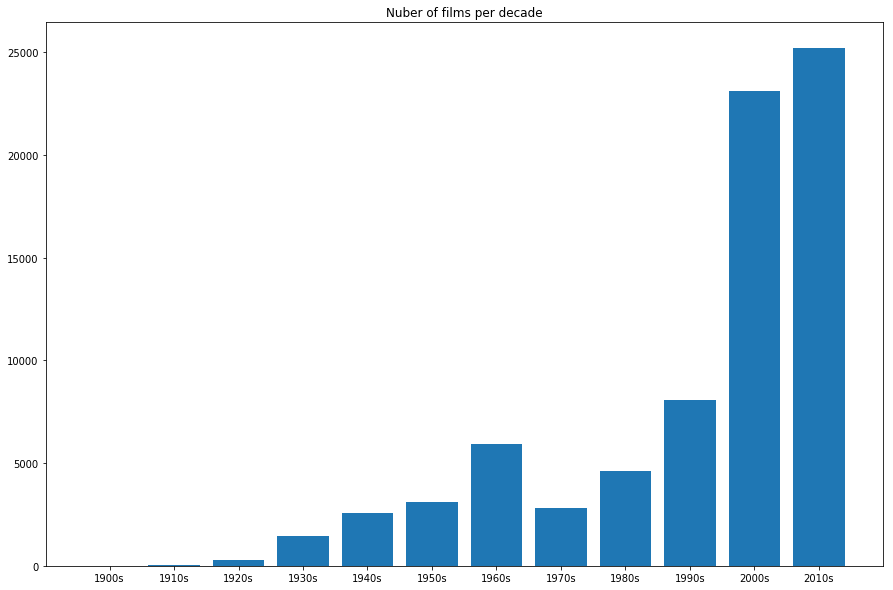

In [13]:
plt.figure(figsize=(15,10))
plt.bar(labels, counts)
plt.title('Nuber of films per decade')
plt.show()

As expected, we have more films in the recent decades.

### 1.1.2 Median number of sentences by year

Our project is about evolution of language used in films, so let's have a peek at how and did it change over time. We will start by showing the median number of sentences for each year. We use median instead of mean since it's a more robust measure so in the case we have some invalid data (like unfinished movie subtitles with just a few sentences) it will behave better.

In [14]:
# get median number of sentences per year
percentile = F.expr('percentile_approx(sentences, 0.5)')
sdf_ = movies.groupby('year').agg(percentile.alias('n_sent_median'))

# convert to Pandas for plotting
sdf = sdf_.toPandas()

# sort the films by year
sdf = sdf.sort_values(by='year')

# convert year to int the 'year' value
sdf['year'] = pd.to_numeric(sdf['year'], errors='coerce', downcast='integer')

# remove films with "Nan" as year value
# since we cannot really use them
sdf = sdf.dropna()
sdf = sdf.reset_index(drop=True)
sdf['year'] = sdf['year'].astype('int')

We will now visualize the median number of sentences by decade. For each decade, we will take the average of medians for that decade. We will ignore year 2020 (for all decades to have exactly 10 years).

In [15]:
years = list(sdf['year'])
labels = []
medians = []

for decade in range(1900, 2020, 10):
    # create bin label
    label = str(decade) + "s"
    labels.append(label)
    
    # calculate count for the bin
    median = 0
    count = 0
    for year in range(decade, decade+10):
        if year in years:
            median += int(sdf.loc[sdf['year'] == year]['n_sent_median'])
            count += 1
    medians.append(median / count)

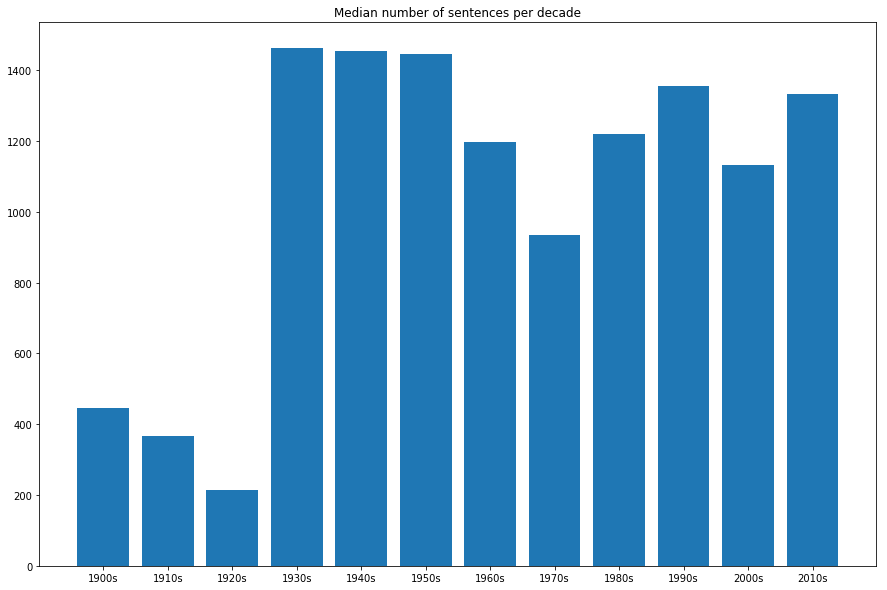

In [16]:
plt.figure(figsize=(15,10))
plt.bar(labels, medians)
plt.title('Median number of sentences per decade')
plt.show()

On this graph we can see a lot of interesting things. Before 1930s, in the era of the silent films, there is a low number of sentences for each movie. In the 40s, the first decade where pretty much every film had sound, we have the highest number of sentences. As we go to our time, we have fewer and fewer sentences by each film. 

This gives credit to the idea that movies are getting more "simpler" by years.

### 1.1.3 Median number of words in sentences by year

We already checked sentences, but they can hide something. The number of words is also important. A movie can have many sentences but most of them can be very short. So let's check the median number of words per year and visualize it.

In [17]:
# get median number of words per year
percentile = F.expr('percentile_approx(words, 0.5)')
wdf_ = movies.groupby('year').agg(percentile.alias('n_word_median'))

# convert to Pandas for plotting
wdf = wdf_.toPandas()

# sort the films by year
wdf = wdf.sort_values(by='year')

# convert year to int the 'year' value
wdf['year'] = pd.to_numeric(wdf['year'], errors='coerce', downcast='integer')

# remove films with "Nan" as year value
# since we cannot really use them
wdf = wdf.dropna()
wdf = wdf.reset_index(drop=True)
wdf['year'] = wdf['year'].astype('int')

In [18]:
years = list(wdf['year'])
labels = []
medians = []

for decade in range(1900, 2020, 10):
    # create bin label
    label = str(decade) + "s"
    labels.append(label)
    
    # calculate count for the bin
    median = 0
    count = 0
    for year in range(decade, decade+10):
        if year in years:
            median += int(wdf.loc[wdf['year'] == year]['n_word_median'])
            count += 1
    medians.append(median / count)

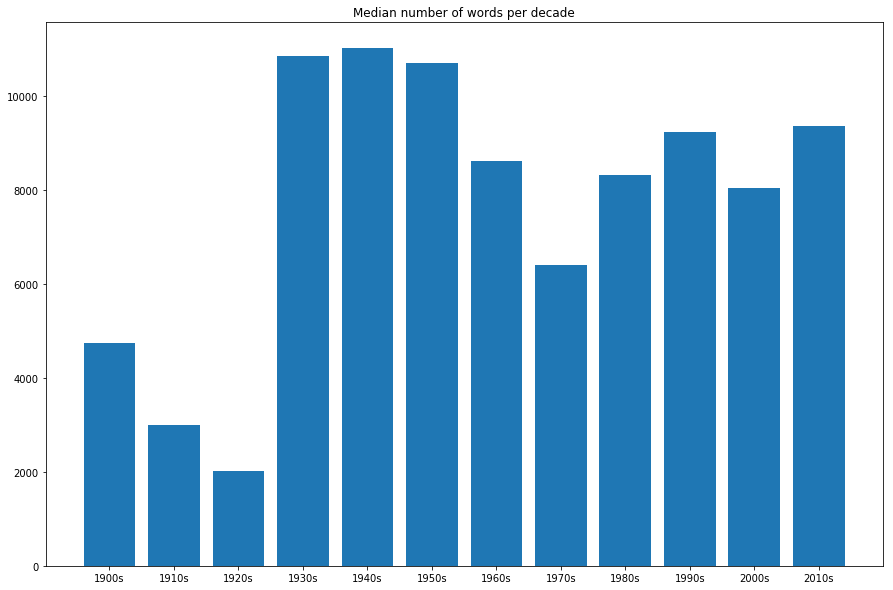

In [19]:
plt.figure(figsize=(15,10))
plt.bar(labels, medians)
plt.title('Median number of words per decade')
plt.show()

The graph seems very similar to the sentences graph in the previous section. So we can assume that newer movies have less sentences, but that number of words for each sentence did not really change.

### 1.1.4 Median film duration by year

Looking at the number of sentences per year we noticed that there is a smaller number of sentences in films in recent decades. However, could it be just because films were longer in the past? 

We will check the median film duration for every year. Again, we will visualize it in decades, taking the average of the median for each year of the decade. 

In [20]:
# get median duration per year
percentile = F.expr('percentile_approx(duration, 0.5)')
ddf_ = movies.groupby('year').agg(percentile.alias('duration_median'))

# convert to Pandas for plotting
ddf = ddf_.toPandas()

# sort the films by year
ddf = ddf.sort_values(by='year')

# convert year to int the 'year' value
ddf['year'] = pd.to_numeric(ddf['year'], errors='coerce', downcast='integer')

# remove films with "Nan" as year value
# since we cannot really use them
ddf = ddf.dropna()
ddf = ddf.reset_index(drop=True)
ddf['year'] = ddf['year'].astype('int')

In [21]:
years = list(ddf['year'])
labels = []
medians = []

for decade in range(1900, 2020, 10):
    # create bin label
    label = str(decade) + "s"
    labels.append(label)
    
    # calculate count for the bin
    median = 0
    count = 0
    for year in range(decade, decade+10):
        if year in years:
            median += int(ddf.loc[wdf['year'] == year]['duration_median'])
            count += 1
    medians.append(median / count)

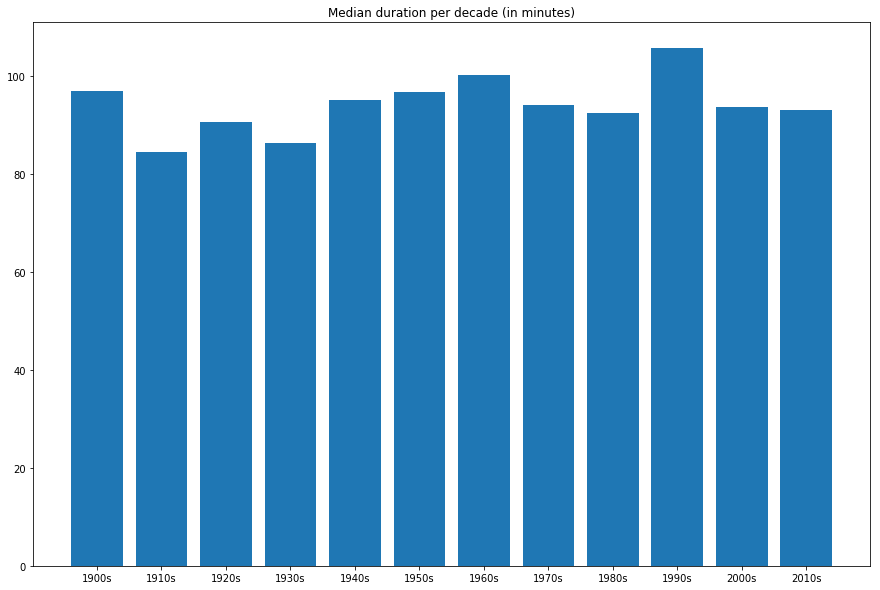

In [22]:
plt.figure(figsize=(15,10))
plt.bar(labels, medians)
plt.title('Median duration per decade (in minutes)')
plt.show()

### 1.2 Subtitle dataframe

Let's start by importing the dataframe and printing its schema.

In [ ]:
subtitle_df = spark.read.parquet("./sentences_until_1999_v2.parquet")

In [16]:
subtitle_df.schema

StructType(List(StructField(_id,IntegerType,true),StructField(sentence,ArrayType(StructType(List(StructField(_VALUE,StringType,true))),true),true),StructField(sentence_length,IntegerType,true)))

Let's count the total amount of sentences we have in our dataframe:

In [12]:
print("Total amount of sentences: {}".format(subtitle_df.count()))

Total amount of sentences: 48996903


Let's continue by counting the total amount of words. Since each sentence is saved as an array of words, we can easily calculate the sentence length by computing the length of each sentence array and if we later sum over this column we will get the total amount of words in the dataframe.

In [11]:
# Create column with sentence length
subtitle_df = subtitle_df.withColumn('sentence_length',F.size(F.col('sentence')))

# Sum all sentence lenegths to get total amount of words
total_amount_of_words = subtitle_df.groupBy().sum().collect()

In [19]:
print("Total amount of words: {}".format(total_amount_of_words[0][0]))

Total amount of words: 5914305524454620


As can be observed in the above printouts, we are dealing with a lot of text. However, it's important to note that not all words will be used in the analysis. We will elaborate more on this below in the **Preprocessing** section.

## 2. Preprocessing 

Before starting the text analysis, we will do some preprocessing steps in order to transform the subtitle texts to a more suitable format and remove undesirable parts. 

As previously mentioned in the parsing section, sentences are stored as lists of strings. For instance the sentence "You're a lovely person." would be represented by the following list:
`["You", "'re", "a", "lovely", "person", "."]`.


There are a few types of words that we do not desire to be part of the analysis, we want to remove common words that do not add any value or meaning to the text. One such category is stop words (https://en.wikipedia.org/wiki/Stop_words). 

We also do not care about the punctuations (https://en.wikipedia.org/wiki/Punctuation) hence we will remove those as well.  

Finally, we also want to transform each word into its "base" form. For instance, the words take, took and taken should be treated as a single word in the analysis and not as three different ones. We will use Lemmatisation (https://en.wikipedia.org/wiki/Lemmatisation) in order to turn "took" and "taken" into their verb base form which is "take". However, we do not only want to lemmatize words but also other cases such as transforming plural words into singular and remove the -ing part of words (walking -> walk) etc.

Note from the above example sentence that contracted words (https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions) are represented as two words in the sentence list. This makes sence when calculating the length of each sentence since a contracted word is actually two words. However, the part on the right hande side of the apostrophe in the contracted word does not add any value to our analysis. Therefore we will drop any word which starts with an apostrophe. 

Finally, we also want to transform each word into lower case. We want the words "Take" and "take" to be treated as the same word.

To summerize, we are doing the folloing preprocessing steps of our subtitle data:

1. Transform each word into lower case 
2. Remove stop words
3. Remove punctuation 
4. Lemmatize words
5. Remove words which starts with an apostrophe

Let's perform the 5 steps described above!

In [8]:
subtitle_df = spark.read.parquet("./sentences_until_1999_v2.parquet")
subtitle_df.show(3)

Py4JJavaError: An error occurred while calling o93.parquet.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1.0 failed 1 times, most recent failure: Lost task 0.0 in stage 1.0 (TID 1, localhost, executor driver): java.io.IOException: Failed to connect to /128.179.251.7:56427
	at org.apache.spark.network.client.TransportClientFactory.createClient(TransportClientFactory.java:245)
	at org.apache.spark.network.client.TransportClientFactory.createClient(TransportClientFactory.java:187)
	at org.apache.spark.rpc.netty.NettyRpcEnv.org$apache$spark$rpc$netty$NettyRpcEnv$$downloadClient(NettyRpcEnv.scala:368)
	at org.apache.spark.rpc.netty.NettyRpcEnv$$anonfun$openChannel$1.apply$mcV$sp(NettyRpcEnv.scala:336)
	at org.apache.spark.rpc.netty.NettyRpcEnv$$anonfun$openChannel$1.apply(NettyRpcEnv.scala:335)
	at org.apache.spark.rpc.netty.NettyRpcEnv$$anonfun$openChannel$1.apply(NettyRpcEnv.scala:335)
	at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1415)
	at org.apache.spark.rpc.netty.NettyRpcEnv.openChannel(NettyRpcEnv.scala:339)
	at org.apache.spark.util.Utils$.doFetchFile(Utils.scala:665)
	at org.apache.spark.util.Utils$.fetchFile(Utils.scala:489)
	at org.apache.spark.executor.Executor$$anonfun$org$apache$spark$executor$Executor$$updateDependencies$5.apply(Executor.scala:755)
	at org.apache.spark.executor.Executor$$anonfun$org$apache$spark$executor$Executor$$updateDependencies$5.apply(Executor.scala:747)
	at scala.collection.TraversableLike$WithFilter$$anonfun$foreach$1.apply(TraversableLike.scala:733)
	at scala.collection.mutable.HashMap$$anonfun$foreach$1.apply(HashMap.scala:99)
	at scala.collection.mutable.HashMap$$anonfun$foreach$1.apply(HashMap.scala:99)
	at scala.collection.mutable.HashTable$class.foreachEntry(HashTable.scala:230)
	at scala.collection.mutable.HashMap.foreachEntry(HashMap.scala:40)
	at scala.collection.mutable.HashMap.foreach(HashMap.scala:99)
	at scala.collection.TraversableLike$WithFilter.foreach(TraversableLike.scala:732)
	at org.apache.spark.executor.Executor.org$apache$spark$executor$Executor$$updateDependencies(Executor.scala:747)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:312)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
	Suppressed: java.lang.NullPointerException
		at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1423)
		... 17 more
Caused by: io.netty.channel.AbstractChannel$AnnotatedNoRouteToHostException: No route to host: /128.179.251.7:56427
	at sun.nio.ch.Net.connect0(Native Method)
	at sun.nio.ch.Net.connect(Net.java:454)
	at sun.nio.ch.Net.connect(Net.java:446)
	at sun.nio.ch.SocketChannelImpl.connect(SocketChannelImpl.java:648)
	at io.netty.util.internal.SocketUtils$3.run(SocketUtils.java:83)
	at io.netty.util.internal.SocketUtils$3.run(SocketUtils.java:80)
	at java.security.AccessController.doPrivileged(Native Method)
	at io.netty.util.internal.SocketUtils.connect(SocketUtils.java:80)
	at io.netty.channel.socket.nio.NioSocketChannel.doConnect(NioSocketChannel.java:308)
	at io.netty.channel.nio.AbstractNioChannel$AbstractNioUnsafe.connect(AbstractNioChannel.java:254)
	at io.netty.channel.DefaultChannelPipeline$HeadContext.connect(DefaultChannelPipeline.java:1291)
	at io.netty.channel.AbstractChannelHandlerContext.invokeConnect(AbstractChannelHandlerContext.java:545)
	at io.netty.channel.AbstractChannelHandlerContext.connect(AbstractChannelHandlerContext.java:530)
	at io.netty.channel.ChannelOutboundHandlerAdapter.connect(ChannelOutboundHandlerAdapter.java:47)
	at io.netty.channel.AbstractChannelHandlerContext.invokeConnect(AbstractChannelHandlerContext.java:545)
	at io.netty.channel.AbstractChannelHandlerContext.connect(AbstractChannelHandlerContext.java:530)
	at io.netty.channel.ChannelDuplexHandler.connect(ChannelDuplexHandler.java:50)
	at io.netty.channel.AbstractChannelHandlerContext.invokeConnect(AbstractChannelHandlerContext.java:545)
	at io.netty.channel.AbstractChannelHandlerContext.connect(AbstractChannelHandlerContext.java:530)
	at io.netty.channel.AbstractChannelHandlerContext.connect(AbstractChannelHandlerContext.java:512)
	at io.netty.channel.DefaultChannelPipeline.connect(DefaultChannelPipeline.java:994)
	at io.netty.channel.AbstractChannel.connect(AbstractChannel.java:259)
	at io.netty.bootstrap.Bootstrap$3.run(Bootstrap.java:252)
	at io.netty.util.concurrent.AbstractEventExecutor.safeExecute(AbstractEventExecutor.java:163)
	at io.netty.util.concurrent.SingleThreadEventExecutor.runAllTasks(SingleThreadEventExecutor.java:403)
	at io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:463)
	at io.netty.util.concurrent.SingleThreadEventExecutor$5.run(SingleThreadEventExecutor.java:858)
	at io.netty.util.concurrent.DefaultThreadFactory$DefaultRunnableDecorator.run(DefaultThreadFactory.java:138)
	... 1 more
Caused by: java.net.NoRouteToHostException: No route to host
	... 29 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1651)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1639)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1638)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1638)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1872)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1821)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1810)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$.mergeSchemasInParallel(ParquetFileFormat.scala:611)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat.inferSchema(ParquetFileFormat.scala:241)
	at org.apache.spark.sql.execution.datasources.DataSource$$anonfun$8.apply(DataSource.scala:203)
	at org.apache.spark.sql.execution.datasources.DataSource$$anonfun$8.apply(DataSource.scala:203)
	at scala.Option.orElse(Option.scala:289)
	at org.apache.spark.sql.execution.datasources.DataSource.getOrInferFileFormatSchema(DataSource.scala:202)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:393)
	at org.apache.spark.sql.DataFrameReader.loadV1Source(DataFrameReader.scala:239)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:227)
	at org.apache.spark.sql.DataFrameReader.parquet(DataFrameReader.scala:622)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.IOException: Failed to connect to /128.179.251.7:56427
	at org.apache.spark.network.client.TransportClientFactory.createClient(TransportClientFactory.java:245)
	at org.apache.spark.network.client.TransportClientFactory.createClient(TransportClientFactory.java:187)
	at org.apache.spark.rpc.netty.NettyRpcEnv.org$apache$spark$rpc$netty$NettyRpcEnv$$downloadClient(NettyRpcEnv.scala:368)
	at org.apache.spark.rpc.netty.NettyRpcEnv$$anonfun$openChannel$1.apply$mcV$sp(NettyRpcEnv.scala:336)
	at org.apache.spark.rpc.netty.NettyRpcEnv$$anonfun$openChannel$1.apply(NettyRpcEnv.scala:335)
	at org.apache.spark.rpc.netty.NettyRpcEnv$$anonfun$openChannel$1.apply(NettyRpcEnv.scala:335)
	at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1415)
	at org.apache.spark.rpc.netty.NettyRpcEnv.openChannel(NettyRpcEnv.scala:339)
	at org.apache.spark.util.Utils$.doFetchFile(Utils.scala:665)
	at org.apache.spark.util.Utils$.fetchFile(Utils.scala:489)
	at org.apache.spark.executor.Executor$$anonfun$org$apache$spark$executor$Executor$$updateDependencies$5.apply(Executor.scala:755)
	at org.apache.spark.executor.Executor$$anonfun$org$apache$spark$executor$Executor$$updateDependencies$5.apply(Executor.scala:747)
	at scala.collection.TraversableLike$WithFilter$$anonfun$foreach$1.apply(TraversableLike.scala:733)
	at scala.collection.mutable.HashMap$$anonfun$foreach$1.apply(HashMap.scala:99)
	at scala.collection.mutable.HashMap$$anonfun$foreach$1.apply(HashMap.scala:99)
	at scala.collection.mutable.HashTable$class.foreachEntry(HashTable.scala:230)
	at scala.collection.mutable.HashMap.foreachEntry(HashMap.scala:40)
	at scala.collection.mutable.HashMap.foreach(HashMap.scala:99)
	at scala.collection.TraversableLike$WithFilter.foreach(TraversableLike.scala:732)
	at org.apache.spark.executor.Executor.org$apache$spark$executor$Executor$$updateDependencies(Executor.scala:747)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:312)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
	Suppressed: java.lang.NullPointerException
		at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1423)
		... 17 more
Caused by: io.netty.channel.AbstractChannel$AnnotatedNoRouteToHostException: No route to host: /128.179.251.7:56427
	at sun.nio.ch.Net.connect0(Native Method)
	at sun.nio.ch.Net.connect(Net.java:454)
	at sun.nio.ch.Net.connect(Net.java:446)
	at sun.nio.ch.SocketChannelImpl.connect(SocketChannelImpl.java:648)
	at io.netty.util.internal.SocketUtils$3.run(SocketUtils.java:83)
	at io.netty.util.internal.SocketUtils$3.run(SocketUtils.java:80)
	at java.security.AccessController.doPrivileged(Native Method)
	at io.netty.util.internal.SocketUtils.connect(SocketUtils.java:80)
	at io.netty.channel.socket.nio.NioSocketChannel.doConnect(NioSocketChannel.java:308)
	at io.netty.channel.nio.AbstractNioChannel$AbstractNioUnsafe.connect(AbstractNioChannel.java:254)
	at io.netty.channel.DefaultChannelPipeline$HeadContext.connect(DefaultChannelPipeline.java:1291)
	at io.netty.channel.AbstractChannelHandlerContext.invokeConnect(AbstractChannelHandlerContext.java:545)
	at io.netty.channel.AbstractChannelHandlerContext.connect(AbstractChannelHandlerContext.java:530)
	at io.netty.channel.ChannelOutboundHandlerAdapter.connect(ChannelOutboundHandlerAdapter.java:47)
	at io.netty.channel.AbstractChannelHandlerContext.invokeConnect(AbstractChannelHandlerContext.java:545)
	at io.netty.channel.AbstractChannelHandlerContext.connect(AbstractChannelHandlerContext.java:530)
	at io.netty.channel.ChannelDuplexHandler.connect(ChannelDuplexHandler.java:50)
	at io.netty.channel.AbstractChannelHandlerContext.invokeConnect(AbstractChannelHandlerContext.java:545)
	at io.netty.channel.AbstractChannelHandlerContext.connect(AbstractChannelHandlerContext.java:530)
	at io.netty.channel.AbstractChannelHandlerContext.connect(AbstractChannelHandlerContext.java:512)
	at io.netty.channel.DefaultChannelPipeline.connect(DefaultChannelPipeline.java:994)
	at io.netty.channel.AbstractChannel.connect(AbstractChannel.java:259)
	at io.netty.bootstrap.Bootstrap$3.run(Bootstrap.java:252)
	at io.netty.util.concurrent.AbstractEventExecutor.safeExecute(AbstractEventExecutor.java:163)
	at io.netty.util.concurrent.SingleThreadEventExecutor.runAllTasks(SingleThreadEventExecutor.java:403)
	at io.netty.channel.nio.NioEventLoop.run(NioEventLoop.java:463)
	at io.netty.util.concurrent.SingleThreadEventExecutor$5.run(SingleThreadEventExecutor.java:858)
	at io.netty.util.concurrent.DefaultThreadFactory$DefaultRunnableDecorator.run(DefaultThreadFactory.java:138)
	... 1 more
Caused by: java.net.NoRouteToHostException: No route to host
	... 29 more


### **(1)** Let's convert each word into its lower case representation:

In [98]:
toLowerSentence = F.udf(lambda x: list(map(lambda y: y.lower(), x)), ArrayType(StringType()))
subtitle_df = subtitle_df.select('_id', toLowerSentence('sentence._VALUE').alias('sentence'))
subtitle_df.show(3)

+-------+--------------------+
|    _id|            sentence|
+-------+--------------------+
|5131043|[they, 're, indep...|
|5131043|[they, 're, affec...|
|5131043|[they, 're, loyal...|
|5131043|[they, 're, sagac...|
|5131043|[they, 're, ineff...|
|5131043|[cats, are, magic...|
|5131043|[they, really, ar...|
|5131043|[probably, the, m...|
|5131043|[they, 're, also,...|
|5131043|[they, 're, very,...|
|5131043|[that, 's, anothe...|
|5131043|[the, domestic, c...|
|5131043|[within, even, th...|
|5131043|[even, after, tho...|
|5131043|[now, ,, scientis...|
|5131043|[for, them, ,, th...|
|5131043|[to, share, one, ...|
|5131043|[perhaps, the, wr...|
|5131043|[", god, made, th...|
|5131043|[today, ,, the, w...|
+-------+--------------------+
only showing top 20 rows



**(2)** We will take help from the NLTK library(https://www.nltk.org/) to filter out stop words. NLTK provides predefined lists of stop words for several different languages, we will use the list for the english language. 

In [99]:
stop_words=set(stopwords.words('english'))
wordInStopWords = F.udf(lambda x: list(filter(lambda y: y not in stop_words,x)), ArrayType(StringType()))
subtitle_df = subtitle_df\
                    .select('_id', wordInStopWords('sentence').alias('sentence'))
subtitle_df.show(3)

+-------+--------------------+
|    _id|            sentence|
+-------+--------------------+
|5131043|['re, independent...|
|5131043|['re, affectionat...|
|5131043|['re, loyal, ;, '...|
|5131043|['re, sagacious, ...|
|5131043|['re, ineffable, ...|
|5131043|    [cats, magic, .]|
|5131043|  [really, magic, .]|
|5131043|[probably, myster...|
|5131043|['re, also, vicio...|
|5131043|['re, cruel, thin...|
|5131043|['s, another, thi...|
|5131043|[domestic, cat, h...|
|5131043|[within, even, de...|
|5131043|[even, thousands,...|
|5131043|[,, scientists, l...|
|5131043|[,, domestic, cat...|
|5131043|[share, one, 's, ...|
|5131043|[perhaps, writer,...|
|5131043|[", god, made, ca...|
|5131043|[today, ,, wester...|
+-------+--------------------+
only showing top 20 rows



**(3)** To filter out punctuations, we can use the built in puncuation list contained in the string class of Python.

In [100]:
punctuation_list=list(string.punctuation)
remvovePunctuation = F.udf(lambda x: list(filter(lambda y: y not in punctuation_list,x)), ArrayType(StringType()))
subtitle_df = subtitle_df\
                    .select('_id', remvovePunctuation('sentence').alias('sentence'))
subtitle_df.show(3)

+-------+--------------------+
|    _id|            sentence|
+-------+--------------------+
|5131043|  ['re, independent]|
|5131043| ['re, affectionate]|
|5131043|['re, loyal, 're,...|
|5131043|['re, sagacious, ...|
|5131043|['re, ineffable, ...|
|5131043|       [cats, magic]|
|5131043|     [really, magic]|
|5131043|[probably, myster...|
|5131043|['re, also, vicious]|
|5131043|['re, cruel, things]|
|5131043|['s, another, thi...|
|5131043|[domestic, cat, h...|
|5131043|[within, even, de...|
|5131043|[even, thousands,...|
|5131043|[scientists, laym...|
|5131043|[domestic, cat, e...|
|5131043|[share, one, 's, ...|
|5131043|[perhaps, writer,...|
|5131043|[god, made, cat, ...|
|5131043|[today, western, ...|
+-------+--------------------+
only showing top 20 rows



**(4)** The NLTK library provies a lemmatizer API.

In [ ]:
lemmatizer = WordNetLemmatizer()
lemmatize = F.udf(lambda x: lemmatizer.lemmatize(x, 'v'), StringType())
subtitle_df = subtitle_df.select('_id', lemmatize(F.col('word')).alias('word'))

**(5)** Remove words starting with an apostrophe

In [101]:
removeApostopheWords = F.udf(lambda x: list(filter(lambda y: y[0] != "'",x)), ArrayType(StringType()))
subtitle_df = subtitle_df\
                    .select('_id', removeApostopheWords('sentence').alias('sentence'))
subtitle_df.show(3)

+-------+--------------------+
|    _id|            sentence|
+-------+--------------------+
|5131043|       [independent]|
|5131043|      [affectionate]|
|5131043|  [loyal, beautiful]|
|5131043|[sagacious, myste...|
|5131043|[ineffable, inscr...|
|5131043|       [cats, magic]|
|5131043|     [really, magic]|
|5131043|[probably, myster...|
|5131043|     [also, vicious]|
|5131043|     [cruel, things]|
|5131043|[another, thing, ...|
|5131043|[domestic, cat, h...|
|5131043|[within, even, de...|
|5131043|[even, thousands,...|
|5131043|[scientists, laym...|
|5131043|[domestic, cat, e...|
|5131043|[share, one, life...|
|5131043|[perhaps, writer,...|
|5131043|[god, made, cat, ...|
|5131043|[today, western, ...|
+-------+--------------------+
only showing top 20 rows



Let's have a look on the poportion of words that has been filtered out during the above steps:

In [104]:
subtitle_df = subtitle_df.withColumn('sentence_length_after_filtering',F.size(F.col('sentence')))
total_amount_of_words = subtitle_df.groupBy().sum().collect()

Py4JJavaError: An error occurred while calling o2537.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 13 in stage 96.0 failed 1 times, most recent failure: Lost task 13.0 in stage 96.0 (TID 5627, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/jakobsvenningsson/spark/spark-2.3.2-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 253, in main
    process()
  File "/Users/jakobsvenningsson/spark/spark-2.3.2-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 248, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/jakobsvenningsson/spark/spark-2.3.2-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 331, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/Users/jakobsvenningsson/spark/spark-2.3.2-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 140, in dump_stream
    for obj in iterator:
  File "/Users/jakobsvenningsson/spark/spark-2.3.2-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 320, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/Users/jakobsvenningsson/spark/spark-2.3.2-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 76, in <lambda>
    return lambda *a: f(*a)
  File "/Users/jakobsvenningsson/spark/spark-2.3.2-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/util.py", line 55, in wrapper
    return f(*args, **kwargs)
  File "/Users/jakobsvenningsson/spark/spark-2.3.2-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 68, in <lambda>
    return lambda *a: g(f(*a))
  File "/Users/jakobsvenningsson/spark/spark-2.3.2-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 68, in <lambda>
    return lambda *a: g(f(*a))
  File "/Users/jakobsvenningsson/spark/spark-2.3.2-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 68, in <lambda>
    return lambda *a: g(f(*a))
  File "<ipython-input-98-6ca0326a5905>", line 1, in <lambda>
TypeError: 'NoneType' object is not iterable

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:330)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:83)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:66)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:284)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:439)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.agg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1651)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1639)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1638)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1638)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1872)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1821)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1810)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2034)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2055)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2074)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2099)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:297)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3200)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3197)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3259)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:77)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3258)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3197)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/jakobsvenningsson/spark/spark-2.3.2-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 253, in main
    process()
  File "/Users/jakobsvenningsson/spark/spark-2.3.2-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 248, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/jakobsvenningsson/spark/spark-2.3.2-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 331, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/Users/jakobsvenningsson/spark/spark-2.3.2-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 140, in dump_stream
    for obj in iterator:
  File "/Users/jakobsvenningsson/spark/spark-2.3.2-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 320, in _batched
    for item in iterator:
  File "<string>", line 1, in <lambda>
  File "/Users/jakobsvenningsson/spark/spark-2.3.2-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 76, in <lambda>
    return lambda *a: f(*a)
  File "/Users/jakobsvenningsson/spark/spark-2.3.2-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/util.py", line 55, in wrapper
    return f(*args, **kwargs)
  File "/Users/jakobsvenningsson/spark/spark-2.3.2-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 68, in <lambda>
    return lambda *a: g(f(*a))
  File "/Users/jakobsvenningsson/spark/spark-2.3.2-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 68, in <lambda>
    return lambda *a: g(f(*a))
  File "/Users/jakobsvenningsson/spark/spark-2.3.2-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 68, in <lambda>
    return lambda *a: g(f(*a))
  File "<ipython-input-98-6ca0326a5905>", line 1, in <lambda>
TypeError: 'NoneType' object is not iterable

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:330)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:83)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.read(PythonUDFRunner.scala:66)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:284)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:439)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.agg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$10$$anon$1.hasNext(WholeStageCodegenExec.scala:614)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:408)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:125)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [ ]:
print("Total amount of words: {}".format(total_amount_of_words[0][0]))

# Plan for milestone 3 below


## 3. Text analysis 

### 3.1 Quantification of text complexity

In this section we will choose and implement a method for getting a measure of textual complexity. 

The measure we are going to use is the Dale-Challe readability forumla, as described here:
https://en.wikipedia.org/wiki/Dale%E2%80%93Chall_readability_formula

We will also try other qantification complexity ideas:
* https://www.geeksforgeeks.org/readability-index-pythonnlp/
* calculate the number of syllabuses in each word https://www.howmanysyllables.com/whataresyllables

### 3.2 Comparison of text complexity by year

In this section we are going to compare the complexity of the movie language for each year.
We want to see if the complexity differs across years.

To do this, we are going to calculate the text complexity measure for each film, and then take the average of complexity for each year.

### 3.3 Comparison of text complexity by genre

In this section we are going to compare the complexity of the movie language for each genre.
Do some genres use more simple language than others?

To do this, we are going to calculate the text complexity measure for each film, and then take the average of complexity for each genre.

### 3.4 Correlation between text complexity of a film and its IMDB rating

In this section we are going to search for correlation between the film text complexity and it's IMDB rating.

To do this, we are going to calculate the text complexity measure for each film, and use correlation coefs and visualization to find evidence for correlation between those variables. 

If we find evidence for correlation, we will try some regression methods on the two variables, such as fitting a regression line.